In [ ]:
# !unzip -o training_data.zip 
# !unzip -o testing_data_final.zip 
# !unzip -o models.zip 
# !unzip -o testing_data_pose.zip 


In [ ]:
# !pip install open3d
# !pip install transforms3d
# !pip install pillow
# !pip install torchsummary

# Training

In [1]:
import json
import multiprocessing
import os
import pickle
from collections import defaultdict
from multiprocessing import Manager, Pool
from multiprocessing.managers import SyncManager
from operator import attrgetter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import open3d
from PIL import Image
from tqdm import tqdm

import utils
from benchmark_utils import pose_utils
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R
import warnings

import torch
from torch.nn import Conv2d
from torch import nn
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
testing_data_dir = "./testing_data_pose_filtered/testing_data/v2.2"
split_dir = "./training_data_filtered/training_data/splits/v2"
training_data_dir = "./training_data_filtered/training_data/v2.2"


# Functions

In [3]:

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
def display_3d(points_viewer):
    points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
    pcd = open3d.geometry.PointCloud()
    pcd.points = points
    pcd.colors = colors
    open3d.visualization.draw_geometries([pcd])


def get_split_files(training_data_dir,split_dir,split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

def np2o3d(points_viewer):
    # points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    # colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
    points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
    pcd = open3d.geometry.PointCloud()
    pcd.points = points
    # pcd.colors = colors
    return pcd

def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def draw_bb(poses_world,meta,rgb):
    box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
    boxed_image = np.array(rgb)
    for i in range(len(poses_world)):
        utils.draw_projected_box3d(
            boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
            thickness=2)
    # plt.plot(Image.fromarray((boxed_image * 255).astype(np.uint8)))
    return(Image.fromarray((boxed_image * 255).astype(np.uint8)))

def point_cloud_image_in_c(meta,depth):
    intrinsic = meta['intrinsic']
    z = depth
    v, u = np.indices(z.shape)
    uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
    points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
    return(points_viewer)

def align_rotation_matrix(vec1, vec2):
    """get rotation matrix between two vectors using scipy
    vec1->source
    vec2->target
    """
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    r = R.align_vectors(vec2, vec1)
    return r[0].as_matrix()

def rot_align_via_PCA(src,tgt):
    try:
        pca = PCA(n_components=3)
        pca.fit(src)
        eig_vec = pca.components_
        normal_src = eig_vec[2, :] 
        pca = PCA(n_components=3)
        pca.fit(tgt)
        eig_vec = pca.components_
        normal_tgt = eig_vec[2, :] 
        return(align_rotation_matrix(normal_src, normal_tgt))
    except:
        return(np.eye(3))
    

def get_best_transform(pcd,obj,skip = 64,train_red_factor = 1):
    registrationResults = []
    init_t = np.eye(4)
    for pcd_tr in tqdm(point_cloud_dict[obj][::train_red_factor],leave=False):
        pcd_tr = pcd_tr[::skip]
        # pcd = pcd[::skip]
        shift = (np.mean(pcd,0)-np.mean(pcd_tr,0))
        init_t[:3,3] = shift
        init_t[:3,:3] = rot_align_via_PCA(pcd_tr,pcd)
        tmp = open3d.pipelines.registration.registration_icp(np2o3d(pcd_tr),
                                                             np2o3d(pcd),
                                                     0.2,init_t)        
        registrationResults.append([len(tmp.correspondence_set),tmp.inlier_rmse,tmp.transformation])
    registrationResults = np.array(registrationResults,dtype=object)
    if(not(np.all(registrationResults[:,0]==0))):
        registrationResults = registrationResults[np.squeeze(np.argwhere(registrationResults[:,0]!=0))]
    registrationResults = registrationResults[np.argsort(-registrationResults[:,0])[:len(registrationResults)//5]]
    T = np.copy(registrationResults[np.argmin(registrationResults[:,1])][2])
    # print(T,registrationResults[np.argmin(registrationResults[:,1])],registrationResults)
    # T[:3,3]+=shift
    return(T)


In [4]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'val')

In [5]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

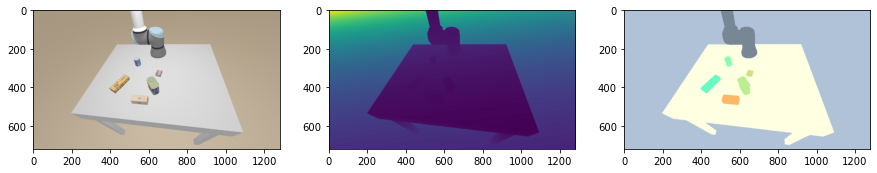

In [6]:
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [7]:
rmin, rmax, cmin, cmax = bbox2(label==39)
crop_img = rgb[rmin:(rmax+1 if (rmax-rmin)%2==1 else rmax),cmin:(cmax+1 if (cmax-cmin)%2==1 else cmax)]
crop_lbl = label[rmin:(rmax+1 if (rmax-rmin)%2==1 else rmax),cmin:(cmax+1 if (cmax-cmin)%2==1 else cmax)]
torch.tensor(crop_img)[torch.tensor(crop_lbl==39)].shape

torch.Size([1464, 3])

In [8]:
(rgb[rmin:(rmax+1 if (rmax-rmin)%2==1 else rmax),
               cmin:(cmax+1 if (cmax-cmin)%2==1 else cmax)]).shape

(52, 38, 3)

# Applying UNet

In [9]:
import torch
from torch.nn import Conv2d
from torch import nn
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader



In [10]:
class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.down1 = self.UnetDoubleConv(3,64)
        self.down2 = self.UnetDoubleConv(64,128)
        self.down3 = self.UnetDoubleConv(128,256)
        self.down4 = self.UnetDoubleConv(256,512)
        self.down5 = self.UnetDoubleConv(512,1024)
        
        self.up1 = self.UnetDoubleConv(64,82)
        self.up2 = self.UnetDoubleConv(128,64)
        self.up3 = self.UnetDoubleConv(256,128)
        self.up4 = self.UnetDoubleConv(512,256)
        self.up5 = self.UnetDoubleConv(1024,512)
        
        self.up2_1 = self.UnetDoubleConv(64,64)
        self.up2_2 = self.UnetDoubleConv(64,64)
        self.upConvT2_1 = self.UnetUpConv(64,64)
        self.upConvT2_2 = self.UnetUpConv(64,64)

        
#         self.upConvT1 = nn.ConvTranspose2d(64,)
        # self.upConvT2 = nn.ConvTranspose2d(128,64,2,2)
        # self.upConvT3 = nn.ConvTranspose2d(256,128,2,2)
        # self.upConvT4 = nn.ConvTranspose2d(512,256,2,2)
        # self.upConvT5 = nn.ConvTranspose2d(1024,512,2,2)
        
        self.upConvT2 = self.UnetUpConv(128,64)
        self.upConvT3 = self.UnetUpConv(256,128)
        self.upConvT4 = self.UnetUpConv(512,256)
        self.upConvT5 = self.UnetUpConv(1024,512)

        self.softmax = torch.nn.Softmax(dim=1)

        self.chut = nn.Conv2d(82,82,1,padding='same')

        
    def UnetDoubleConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def UnetUpConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,2,2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
            
    
    def forward(self,x):
        # x = x.permute(0, 3, 1, 2)
        convOut1 = self.down1(x)
        maxPool1 = nn.MaxPool2d(2)(convOut1)
        convOut2 = self.down2(maxPool1)
        maxPool2 = nn.MaxPool2d(2)(convOut2)
        convOut3 = self.down3(maxPool2)
        # maxPool3 = nn.MaxPool2d(2)(convOut3)
        # convOut4 = self.down4(maxPool3)
        # maxPool4 = nn.MaxPool2d(2)(convOut4)
        # convOut5 = self.down5(maxPool4)
#         maxPool5 = nn.MaxPool2d(2)(convOut5)
        
        
        # upPool4 = self.upConvT4(convOut4)
        # upPool4Cat = torch.cat([upPool4,convOut3],dim=1)
        # incConvOut3 = self.up4(upPool4Cat)
        # upPool3 = self.upConvT3(incConvOut3)
        upPool3 = self.upConvT3(convOut3)
        upPool3Cat = torch.cat([upPool3,convOut2],dim=1)
        incConvOut2 = self.up3(upPool3Cat)
        upPool2 = self.upConvT2(incConvOut2)
        upPool2Cat = torch.cat([upPool2,convOut1],dim=1)
        incConvOut1 = self.up2(upPool2Cat)
        
        upPool2_1 = self.upConvT2_1(incConvOut1)
        incConvOut1_1 = self.up2_1(upPool2_1)
        upPool2_2 = self.upConvT2_1(incConvOut1_1)
        incConvOut1_2 = self.up2_2(upPool2_2)
        
        out1 = self.up1(incConvOut1_2)
        out = self.chut(out1)
        # out = self.softmax(out)
        # out = out.permute(0,3,1,2)
        
        # upPool3 = self.upConvT3(incConvOut3)
        # incConvOut2 = self.up2(upPool3)
        
        return(out)
        

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, rgb_files,label_files):
        super().__init__()
        self.image_names = rgb_files
        self.label_names = label_files

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        rgb = np.array(Image.open(self.image_names[idx]))
        rgb = rgb[::4,::4]
        img = (
          torch.tensor(rgb / 255.0, dtype=torch.float32)
          .permute(2, 0, 1)
          .contiguous()
        )
        if(not(self.label_names is None)):
            label = np.array(Image.open(self.label_names[idx]))
            label = label[::1,::1]
            lbl = torch.tensor(label, dtype=torch.int64).contiguous()
        else:
            lbl = None
        return {"image": img, "label": lbl}

## Training

In [10]:
multi_inputdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet().to(multi_inputdevice)
summary(model,(3,180,320))
torch.cuda.empty_cache()

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 180, 320]           1,792
       BatchNorm2d-2         [-1, 64, 180, 320]             128
              ReLU-3         [-1, 64, 180, 320]               0
            Conv2d-4         [-1, 64, 180, 320]          36,928
       BatchNorm2d-5         [-1, 64, 180, 320]             128
              ReLU-6         [-1, 64, 180, 320]               0
            Conv2d-7         [-1, 128, 90, 160]          73,856
       BatchNorm2d-8         [-1, 128, 90, 160]             256
              ReLU-9         [-1, 128, 90, 160]               0
           Conv2d-10         [-1, 128, 90, 160]         147,584
      BatchNorm2d-11         [-1, 128, 90, 160]             256
             ReLU-12         [-1, 128, 90, 160]               0
           Conv2d-13          [-1, 256, 45, 80]         295,168
      BatchNorm2d-14          [-1, 256,

In [12]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'train')
rgb_files_val, depth_files_val, label_files_val, meta_files_val = get_split_files(training_data_dir,split_dir,'val')

In [13]:
batch_size = 1
dataset_train = Dataset(rgb_files,label_files)
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,num_workers=2)
dataset_val = Dataset(rgb_files_val,label_files_val)
valloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True,num_workers=2)

In [ ]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet()
model = model.to(device=device)


In [15]:
import datetime


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.004)

epochs= 10

min_valid_loss = np.inf


for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    with tqdm(trainloader, unit="batch") as tepoch:
        for data in tepoch:
            inputs, labels = data['image'],data["label"]
            tepoch.set_description(f"Epoch {epoch}")
            # trainset, valset = torch.utils.data.random_split(dataloader, [950,50])
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            # labels = torch.unsqueeze(torch.div(labels,255),1)
            # labels = labels.type(torch.LongTensor)

            # print('a')
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print('b')

            # print statistics
            tepoch.set_postfix(loss=loss.item())
            running_loss += loss.item()
            # if i % 100 == 0:    # print every 2000 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #     running_loss = 0.0
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data_val in valloader:
        # if torch.cuda.is_available():
        data, labels = data_val['image'],data_val["label"]
        data, labels = data.to(device), labels.to(device)
        
        target = model(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)

    print(f' Validation Loss: {valid_loss / len(valloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        # torch.save(model.state_dict(), '/content/drive/Othercomputers/My PC/UCSD Acads/Quarter 1/CSE 291/HW3/saved_model.pth')
        torch.save(model.state_dict(), f'./weights/UNet2/saved_model_{datetime.datetime.now().strftime("%Y_%m_%dT%H_%M_%S")}_valloss_{valid_loss}.pth')

    # model.eval()
    # with tqdm(valloader, unit="batch") as tepoch:
    #   for inputs, labels in tepoch:
    #     tepoch.set_description(f"Epoch {epoch}")


Epoch 0: 100%|██████████| 3964/3964 [19:32<00:00,  3.38batch/s, loss=0.00643]


 Validation Loss: 5.134216004635318e-05
Validation Loss Decreased(inf--->0.012117) 	 Saving The Model


Epoch 1: 100%|██████████| 3964/3964 [19:39<00:00,  3.36batch/s, loss=0.0117] 


 Validation Loss: 0.008113059452024557


Epoch 2: 100%|██████████| 3964/3964 [19:31<00:00,  3.38batch/s, loss=0.00785]


 Validation Loss: 0.0003912459932646509


Epoch 3: 100%|██████████| 3964/3964 [19:33<00:00,  3.38batch/s, loss=0.00221]


 Validation Loss: 0.0008217451178421408


Epoch 4: 100%|██████████| 3964/3964 [19:33<00:00,  3.38batch/s, loss=0.00135] 


 Validation Loss: 0.00013185709999021837


Epoch 5: 100%|██████████| 3964/3964 [19:32<00:00,  3.38batch/s, loss=0.00352] 


 Validation Loss: 0.005919886342549728


Epoch 6: 100%|██████████| 3964/3964 [19:33<00:00,  3.38batch/s, loss=0.00145] 


 Validation Loss: 0.001246485038328979


Epoch 7: 100%|██████████| 3964/3964 [19:33<00:00,  3.38batch/s, loss=0.0047]  


 Validation Loss: 0.00010048040046782817


Epoch 8: 100%|██████████| 3964/3964 [19:35<00:00,  3.37batch/s, loss=0.00301] 


 Validation Loss: 0.00029557220385236253


Epoch 9: 100%|██████████| 3964/3964 [19:34<00:00,  3.38batch/s, loss=0.00183] 


 Validation Loss: 0.00020193097071122314


In [24]:
torch.save(model.state_dict(), f'./weights/UNet2/UNet2_saved_model_{datetime.datetime.now().strftime("%Y_%m_%dT%H_%M_%S")}_final.pth')


## Checking Segmentation

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_loaded = Unet()
pth_name = "UNet2_saved_model_2022_12_08T00_53_08_final.pth"
model_loaded.load_state_dict(torch.load(f'./weights/UNet2/{pth_name}',map_location=device))

model_loaded.to(device)

Unet(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [13]:
with open("./testing_data_pose_filtered/testing_data/test.txt",'r') as f:
    prefix = [os.path.join(testing_data_dir, line.strip()) for line in f if line.strip()]
    rgb_test_files = [p + "_color_kinect.png" for p in prefix]
    depth_test_files = [p + "_depth_kinect.png" for p in prefix]
    meta_test_files= [p + "_meta.pkl" for p in prefix]


In [14]:
dataset_test = Dataset(rgb_test_files,None)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


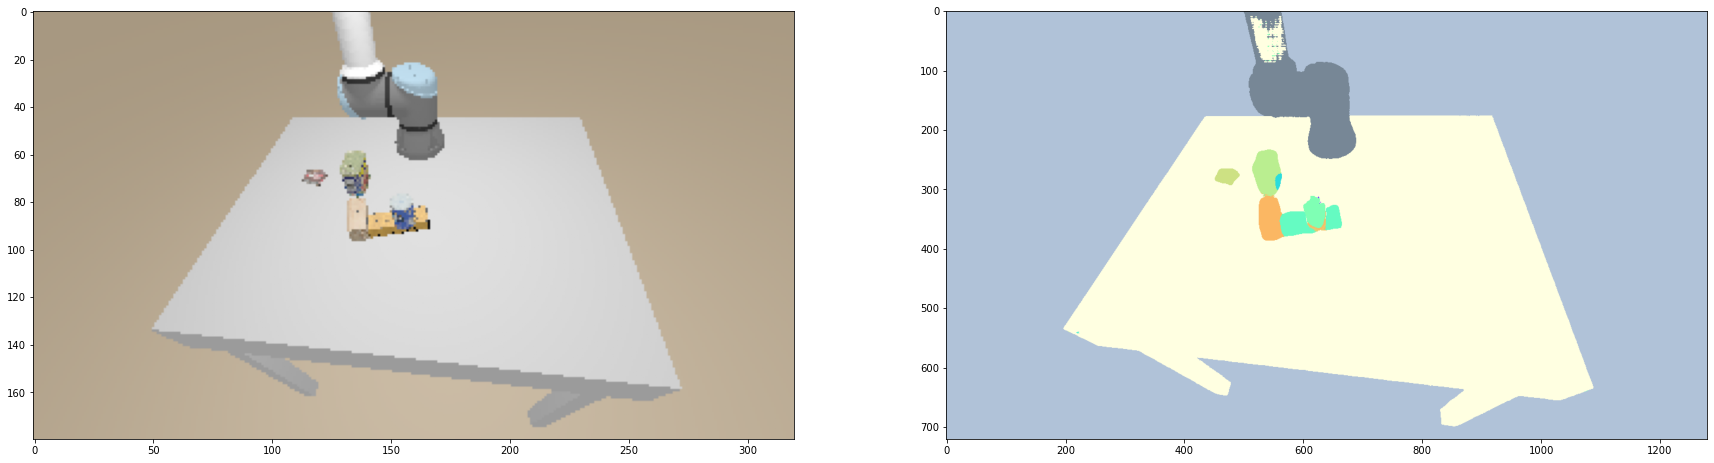

In [15]:
import numpy as np
import matplotlib.pyplot as plt

rgb = dataset_test[0]['image']

model_loaded.eval()
pred_label = np.argmax(np.transpose(np.squeeze(model_loaded(torch.unsqueeze(rgb,0).to(device)).cpu().detach().numpy(),0),(1,2,0)),-1)
# pred_label = 
# model.eval()
# test_labels = np.argmin(np.transpose(model(torch.tensor(np.transpose(test_images,(0,3,1,2))).float().to(device)).detach().cpu().numpy(),(0,2,3,1)),axis=-1)*255

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(rgb,(1,2,0)))
# plt.subplot(1, 3, 2)
# plt.imshow(COLOR_PALETTE[label])
plt.subplot(1, 2, 2)
plt.imshow(COLOR_PALETTE[pred_label])  # draw colorful segmentation

## Adding PointNet

## Getting PointCloud

In [17]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

In [18]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'train')

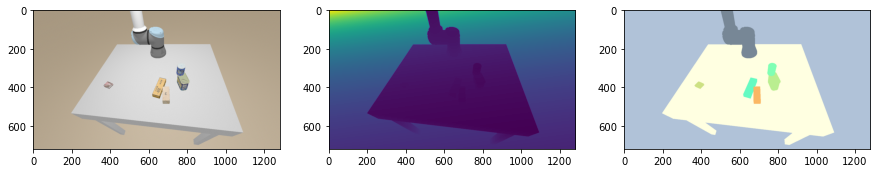

In [19]:
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [20]:
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
meta = load_pickle(meta_files[0])
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
pc_image = point_cloud_image_in_c(meta,depth)
extrinsic = meta['extrinsic']
extr_inv = np.linalg.inv(extrinsic)
for objind in meta['object_ids']:
    seg_pcd = pc_image[label==objind]
    seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3]

    world_pose = meta['poses_world'][objind]
    pose_inv = np.linalg.inv(world_pose)
    seg_pcd_base = seg_pcd_world@ pose_inv[:3, :3].T + pose_inv[:3, 3]
    
    
#     display_3d(seg_pcd_base)


In [21]:
label==objind

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Image Features

In [43]:
from collections import defaultdict
class PcdCropToPoseDataset(torch.utils.data.Dataset):
    def __init__(self, rgb_files,label_files,depth_files,meta_files,ship = 1):
        super().__init__()
        self.image_names = rgb_files
        self.label_names = label_files
        self.depth_files = depth_files
        self.meta_files = meta_files
        self.skip = 1 
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        rgb = np.array(Image.open(self.image_names[idx]))
#         img = (
#           torch.tensor(rgb / 255.0, dtype=torch.float32)
#           .permute(2, 0, 1)
#           .contiguous()
#         )
        
        label = np.array(Image.open(self.label_names[idx]))
#         lbl = torch.tensor(label, dtype=torch.int64).contiguous()

#         pcd_data = defaultdict(dict)
        crop_imgs = []
        crop_lbls = []
        seg_pcd_worlds = []
        world_poses = []
        obj_inds = []
        
        meta = load_pickle(self.meta_files[idx])
        pc_image = point_cloud_image_in_c(meta,depth)
        extrinsic = meta['extrinsic']
        extr_inv = np.linalg.inv(extrinsic)
        for objind in meta['object_ids']:
            rmin, rmax, cmin, cmax = bbox2(label==objind)
            crop_rgb = rgb[rmin:(rmax+1 if (rmax-rmin)%2==1 else rmax),
               cmin:(cmax+1 if (cmax-cmin)%2==1 else cmax)]
            crop_img_t = (
                torch.tensor(crop_rgb/ 255.0, dtype=torch.float32)
                .permute(2, 0, 1)
                .contiguous()
            )
            crop_lbl = label[rmin:(rmax+1 if (rmax-rmin)%2==1 else rmax),cmin:(cmax+1 if (cmax-cmin)%2==1 else cmax)]
            crop_lbl_t = torch.tensor(crop_lbl, dtype=torch.int64).contiguous()
            
            seg_pcd = pc_image[label==objind]
            seg_pcd_world = seg_pcd@ extr_inv[:3, :3].T + extr_inv[:3, 3] 
            seg_pcd_world_t = (
                torch.tensor(seg_pcd_world,dtype=torch.float32)
                .permute(1,0)
                .contiguous()
            )

            world_pose = meta['poses_world'][objind]
            world_pose_t = (
                torch.tensor(world_pose, dtype=torch.float32)
                .contiguous()
            )
            crop_imgs += [crop_img_t]
            crop_lbls += [crop_lbl_t]
            seg_pcd_worlds += [seg_pcd_world_t]
            world_poses += [world_pose_t]
            obj_inds += [objind]
            
        return {"image": crop_imgs, 
                "label": crop_lbls, 
                "seg_pcd_world":seg_pcd_worlds,
               "world_pose":world_poses,
               "obj_inds": obj_inds}

In [23]:
import torch
from torch.nn import Conv2d
from torch import nn
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F


class FeatureGen(torch.nn.Module):
    def __init__(self):
        super(FeatureGen,self).__init__()
        self.down1 = self.UnetDoubleConv(3,32)
        self.down2 = self.UnetDoubleConv(32,64)
        self.down3 = self.UnetDoubleConv(128,256)
        self.down4 = self.UnetDoubleConv(256,512)
        self.down5 = self.UnetDoubleConv(512,1024)
        
        self.up1 = self.UnetDoubleConv(32,32)
        self.up2 = self.UnetDoubleConv(64,32)
        self.up3 = self.UnetDoubleConv(256,128)
        self.up4 = self.UnetDoubleConv(512,256)
        self.up5 = self.UnetDoubleConv(1024,512)
        
        
        self.upConvT2 = self.UnetUpConv(64,32)
        self.upConvT3 = self.UnetUpConv(256,128)
        self.upConvT4 = self.UnetUpConv(512,256)
        self.upConvT5 = self.UnetUpConv(1024,512)

        self.softmax = torch.nn.Softmax(dim=1)

        self.chut = nn.Conv2d(32,32,1,padding='same')
        
        self.fc1 = nn.Linear(32, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 32)


        
    def UnetDoubleConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def UnetUpConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,2,2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
            
    
    def forward(self,x):
        # x = x.permute(0, 3, 1, 2)
        convOut1 = self.down1(x)
        maxPool1 = nn.MaxPool2d(2)(convOut1)
        convOut2 = self.down2(maxPool1)
#         maxPool2 = nn.MaxPool2d(2)(convOut2)
#         convOut3 = self.down3(maxPool2)

#         upPool3 = self.upConvT3(convOut3)
#         upPool3Cat = torch.cat([upPool3,convOut2],dim=1)
#         incConvOut2 = self.up3(upPool3Cat)
        upPool2 = self.upConvT2(convOut2)
        upPool2Cat = torch.cat([upPool2,convOut1],dim=1)
        incConvOut1 = self.up2(upPool2Cat)
        
        out1 = self.up1(incConvOut1)
        out = self.chut(out1)
#         out3 = F.relu(self.bn4(self.fc1(incConvOut1)))

#         out = self.fc2(incConvOut1)
        
        # out = self.softmax(out)
        # out = out.permute(0,3,1,2)
        
        # upPool3 = self.upConvT3(incConvOut3)
        # incConvOut2 = self.up2(upPool3)
        
        return(out)

In [61]:
multi_inputdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeatureGen().to(multi_inputdevice)
test = Variable(torch.rand(1,3,4,4)).to(multi_inputdevice)
print(model(test).shape)
# # summary(model,(3,180*4,320*4))


torch.Size([1, 32, 4, 4])


## PointNet

In [174]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F


class STN3d(nn.Module):
    def __init__(self,output_feats=128,global_feats=True):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_feats)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        
        self.global_feats = global_feats


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        if(not self.global_feats):
            return x
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = F.relu((self.fc1(x)))
        x = F.relu((self.fc2(x)))
        x = self.fc3(x)
        return x




In [176]:
# multi_inputdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = STN3d().to(multi_inputdevice)
# summary(model,(3,1000))
# torch.cuda.empty_cache()

In [178]:
sim_data = Variable(torch.rand(1,3,2500))
trans = STN3d(9)
out = trans(sim_data)
print('stn', out.size())
# print('loss', feature_transform_regularizer(out))


stn torch.Size([1, 9])


# Dense Fusion

In [227]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F


class DenseFusion(nn.Module):
    def __init__(self):
        super(DenseFusion, self).__init__()
        self.stn = STN3d()
        self.featureGen = FeatureGen()
        self.down1 = self.UnetDoubleConv(160,200)
        self.down2 = self.UnetDoubleConv(200,256)
        self.down3 = self.UnetDoubleConv(256,512)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(64, 9)

    
            
    def UnetDoubleConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )



    def forward(self, images,labels,seg_pcd_worlds,objinds):
        poses = []
        for image,label,seg_pcd_world,objind in zip(images,labels,seg_pcd_worlds,objinds):
            fv = featureGen(image.unsqueeze(0)).squeeze(0)
            pnf = stn(seg_pcd_world.unsqueeze(0)).squeeze(0)
            pnf_fv = torch.cat([fv,pnf.unsqueeze(-1).unsqueeze(-1).expand(-1,*fv.shape[1:])]).unsqueeze(0)
            x = self.down1(pnf_fv)
            x = self.down2(x)
            print(x.shape)
            x = nn.Flatten()(x)
            print(x.shape)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            poses+=[x]
            
        
            
            
        
        return torch.stach(x)


In [228]:
rgb_files, depth_files, label_files, meta_files = get_split_files(training_data_dir,split_dir,'train')

batch_size = 2
denseFusionDataset = PcdCropToPoseDataset(rgb_files,label_files,depth_files,meta_files)
trainloader = DataLoader(denseFusionDataset, batch_size=batch_size, shuffle=True,num_workers=2)


In [229]:
denseFusion = DenseFusion()

In [230]:
denseFusion(denseFusionDataset[0]["image"],
           denseFusionDataset[0]["label"],
           denseFusionDataset[0]["seg_pcd_world"],
           denseFusionDataset[0]["obj_inds"]
           )

torch.Size([1, 200, 106, 68])
torch.Size([1, 1671168])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1671168 and 512x128)

In [193]:
image = denseFusionDataset[0]["image"][1]
label = denseFusionDataset[0]["label"][1]
seg_pcd_world = denseFusionDataset[0]["seg_pcd_world"][1]
world_pose = denseFusionDataset[0]["world_pose"][1]
objind = denseFusionDataset[0]["obj_inds"][1]


In [194]:
stn = STN3d()
featureGen = FeatureGen()

In [195]:
fv = featureGen(image.unsqueeze(0)).squeeze(0)

torch.Size([68, 48])

In [197]:
fv.permute(1,2,0).shape

torch.Size([68, 48, 32])

In [198]:
seg_pcd_world.unsqueeze(0).shape

torch.Size([1, 3, 2567])

In [199]:
pnf = stn(seg_pcd_world.unsqueeze(0)).squeeze(0)

In [200]:
pnf.shape

torch.Size([128])

In [206]:
pnf_fv = torch.cat([fv,pnf.unsqueeze(-1).unsqueeze(-1).expand(-1,*fv.shape[1:])]).unsqueeze(0)

In [209]:
pnf_fv.shape

torch.Size([1, 160, 68, 48])

In [208]:
nn.Conv2d(160,200,3,padding='same')(pnf_fv).shape

torch.Size([1, 200, 68, 48])

In [126]:
pnf.expand(-1,110,72).shape

RuntimeError: The expanded size of the tensor (72) must match the existing size (128) at non-singleton dimension 2.  Target sizes: [-1, 110, 72].  Tensor sizes: [128]

In [113]:
torch.cat([fv,pnf],0)

RuntimeError: torch.cat(): Tensors must have same number of dimensions: got 3 and 1

In [73]:
                "label": crop_lbls, 
                "seg_pcd_world":seg_pcd_worlds,
               "world_pose":world_poses}

In [75]:
fv = featureGen(torch.unsqueeze(denseFusionDataset[0]['image'],0))

torch.Size([1, 32, 720, 1280])


In [84]:
torch.squeeze(fv,0).shape

torch.Size([32, 720, 1280])

In [96]:
fv.size()

torch.Size([1, 32, 720, 1280])

In [95]:
tm

NameError: name 'tm' is not defined

In [98]:
torch.masked_select(fvtorch.unsqueeze(denseFusionDataset[0]['label']==80,0).expand(fv.size()).shape

torch.Size([1, 32, 720, 1280])

In [42]:
pcd_data = denseFusionDataset[0]['pcd_data']
for k in pcd_data:
    print(pcd_data[k]['world_pcd'].shape)

torch.Size([4320, 3])
torch.Size([2567, 3])
torch.Size([4148, 3])
torch.Size([1171, 3])
torch.Size([3268, 3])
